In [ ]:
# !pip install git+https://gitlab.wikimedia.org/repos/research/research-common.git
from research_common.spark import create_yarn_spark_session
from pyspark.sql import functions as F

conf =  {
    "spark.dynamicAllocation.maxExecutors": 50,
    "spark.executor.cores": 4,
    "spark.sql.shuffle.partitions": 999,
    "spark.executor.memory": "14g",
    "spark.executor.memoryOverhead": "2g",
}
spark = create_yarn_spark_session(app_id='knowledge_gaping',extra_config=conf)

# Intersections between gaps

This notebook illustrates how to calculate metrics about intersections between different content gaps.

## Geography x Gender gap

In this notebook, we calculate the standard quality metric (e.g. the number of articles that meet the standard quality requirements) for the intersection between the geography gap on the WMF region level with a simplified gender gap.

The input for the intersection metris are the raw content gap features and the metric features datasets, see the schema on [datahub](https://datahub.wikimedia.org/container/urn:li:container:c46841c15303811743bb5cece7fba53a/Entities?is_lineage_mode=false)

In [2]:
content_gap_features_df = spark.table("content_gap_metrics.content_gap_features")
metric_features_df = spark.table("content_gap_metrics.metric_features")

content_gap_features_df.printSchema()

root
 |-- wiki_db: string (nullable = true)
 |-- page_id: long (nullable = true)
 |-- qitem_id: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- is_human: boolean (nullable = true)
 |-- gender: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- gender_qid: string (nullable = true)
 |    |    |-- gender: string (nullable = true)
 |-- sexual_orientation: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- sexual_orientation_qid: string (nullable = true)
 |    |    |-- sexual_orientation: string (nullable = true)
 |-- geographic: struct (nullable = true)
 |    |-- geospatial_model: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- geocoordinates: struct (nullable = true)
 |    |    |    |    |-- lat: float (nullable = true)
 |    |    |    |    |-- lon: float (nullable = true)
 |    |    |    |-- geocode: struct (nullable = true)
 |    |    |    |   

In [3]:
@F.udf(returnType="string")
def gender_diverse(gender):
    match gender:
        case "male" | "cisgender male":
            label = "Man"
        case "female" | "cisgender female":
            label = "Woman"
        case _:
            label = 'Gender Diverse'
    return label


gender_diverse_df = (content_gap_features_df
    .where(F.col("is_human"))
    .where(F.col("gender").isNotNull())
    .withColumn("gender", F.explode("gender.gender")) # possibly multiple genders labels
    .where(F.col("gender").isNotNull())
    .withColumn("gender", gender_diverse("gender"))
)

region_df = (gender_diverse_df
    .where(F.col("geographic").isNotNull())
    .where(F.col("geographic.cultural_model").isNotNull())
    .withColumn("wmf_region", F.explode("geographic.cultural_model.wikimedia_region"))
    .where(F.col("wmf_region").isNotNull())
)


geoXgender_df = (region_df
    .select("wiki_db", "page_id", "page_title", "qitem_id", "gender", "wmf_region")
)

geoXgender_df.cache().show(truncate=False)


24/02/02 20:40:28 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


+-------+--------+---------------------------+---------+------+---------------------------------------+
|wiki_db|page_id |page_title                 |qitem_id |gender|wmf_region                             |
+-------+--------+---------------------------+---------+------+---------------------------------------+
|eswiki |7755885 |Regina_Arrieta             |Q28419114|Woman |Northern & Western Europe              |
|ptwiki |6643044 |Michael_Kukrle             |Q27050091|Man   |Central & Eastern Europe & Central Asia|
|ptwiki |6643044 |Michael_Kukrle             |Q27050091|Man   |Central & Eastern Europe & Central Asia|
|enwiki |13094886|Mandi_Lampi                |Q6748051 |Woman |Northern & Western Europe              |
|dewiki |2449744 |Karl_Surkamp               |Q1416222 |Man   |Northern & Western Europe              |
|arzwiki|1053291 |اندريا_ماير                |Q494434  |Woman |Northern & Western Europe              |
|huwiki |1786481 |Glenn_Ford                 |Q212048  |Man   |N

In [4]:
metric_features_df.printSchema()

standard_quality_df = metric_features_df.select(["wiki_db", "page_id", "time_bucket", "standard_quality"])



root
 |-- wiki_db: string (nullable = true)
 |-- page_id: long (nullable = true)
 |-- time_bucket: string (nullable = true)
 |-- article_created: integer (nullable = true)
 |-- pageviews: long (nullable = true)
 |-- quality_score: float (nullable = true)
 |-- standard_quality: integer (nullable = true)
 |-- page_revision_count: long (nullable = true)



In [6]:

df = geoXgender_df.join(
        standard_quality_df, ["wiki_db", "page_id"], "inner"
    ).cache()

df.show()

+-------+-------+----------+--------+------+-------------+-----------+----------------+
|wiki_db|page_id|page_title|qitem_id|gender|   wmf_region|time_bucket|standard_quality|
+-------+-------+----------+--------+------+-------------+-----------+----------------+
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2021-06|               0|
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2019-11|               0|
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2023-11|               0|
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2022-08|               0|
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2022-10|               0|
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2021-07|               0|
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2017-02|               0|
|acewiki|  10174|Phife_Dawg|Q1370892|   Man|North America|    2018-02|               0|
|acewiki|  10174|Phife_Dawg|Q137

In [7]:
geoXgender = (df
    .groupby(["gender", "wmf_region", "time_bucket"])
    .agg(F.sum("standard_quality").alias("standard_quality_count"))
).toPandas()

In [8]:
geoXgender = geoXgender.sort_values("time_bucket")
geoXgender

gender                               wmf_region time_bucket  \
1608             Man                Northern & Western Europe     2001-01   
1334             Man                            North America     2001-01   
5594             Man  Central & Eastern Europe & Central Asia     2001-01   
5350           Woman          East, Southeast Asia, & Pacific     2001-01   
5845           Woman                            North America     2001-01   
...              ...                                      ...         ...   
5330  Gender Diverse          East, Southeast Asia, & Pacific     2023-12   
3744             Man               Middle East & North Africa     2023-12   
812   Gender Diverse                            North America     2023-12   
1115           Woman                Northern & Western Europe     2023-12   
3199  Gender Diverse                Northern & Western Europe     2023-12   

      standard_quality_count  
1608                     0.0  
1334                     0.0  
5594                     NaN  
5350                     0.0  
5845                     0.0  
...                      ...  
5330                   462.0  
3744                 28928.0  
812                   2359.0  
1115                115810.0  
3199                   980.0  

[6311 rows x 4 columns]

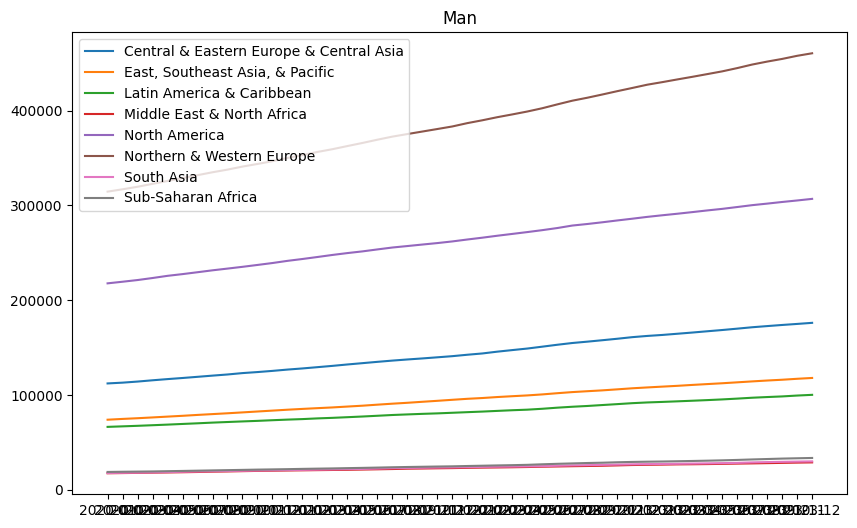

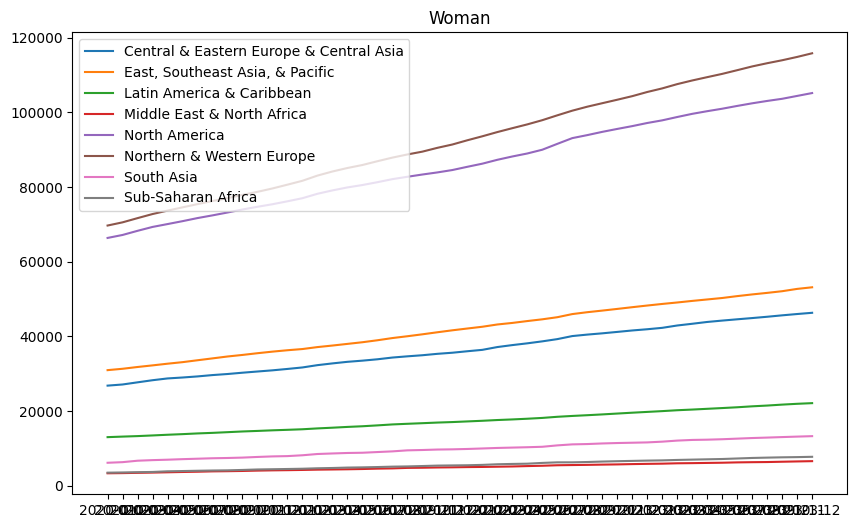

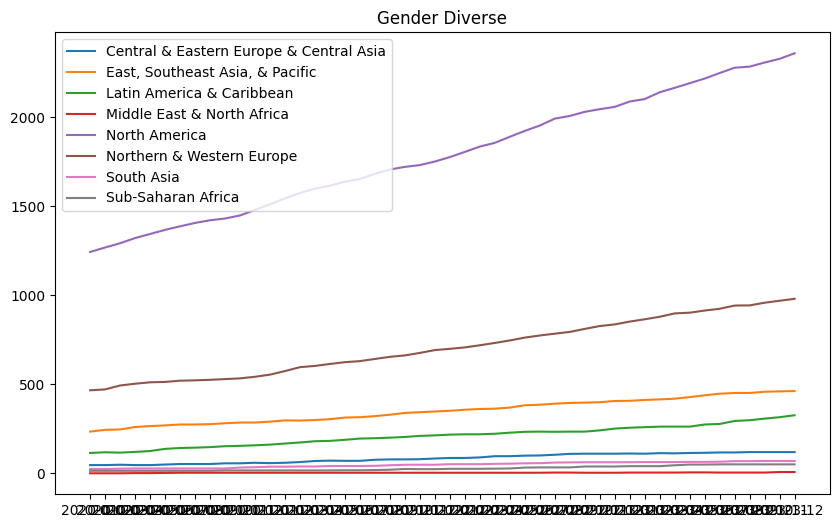

In [17]:
import matplotlib.pyplot as plt

genders = set(geoXgender.gender)

filtered = geoXgender[geoXgender.time_bucket>="2020-01"]

for gender in genders:

    country_df = filtered[filtered.gender==gender]
    plt.figure(figsize=(10, 6))

    # For each wmf region in the grouped country DataFrame, plot the values
    for region, gender_df in country_df.groupby('wmf_region'):
        plt.plot(gender_df['time_bucket'], gender_df['standard_quality_count'], label=region)

    plt.title(gender)
    plt.legend()
    # plt.show()
